In [1]:
import pandas as pd
import numpy as np
import math
import os 
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import datetime
import calendar
import matplotlib.pyplot as plt

In [2]:
chunksize = 100000
chunk_list = []

chunks = pd.read_json("../lighter_books.json", lines=True, chunksize=chunksize)

columns_to_drop = ["isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]
for chunk in tqdm(chunks):
    chunk.drop(columns=columns_to_drop, inplace=True)
    chunk = chunk[chunk['title'].notna()]

    chunk_list.append(chunk)

books = pd.concat(chunk_list, ignore_index=True)

# Cleaning the dataset
books = books[books['ratings_count'] >= 0]
books = books[books['text_reviews_count'] >= 0]

books['num_pages'] = books['num_pages'].replace('', np.nan)
books['num_pages'].fillna(0, inplace=True)
books['num_pages'] = books['num_pages'].astype(int)
books = books[books['num_pages'] >= 0]
books.drop_duplicates(subset='id', keep='first', inplace=True)

# Print information about the 'books' DataFrame
print(books.info())
print(books.columns)
print(books.head())


0it [00:00, ?it/s]

71it [10:40,  9.02s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027431 entries, 0 to 7027430
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   title                      object 
 2   authors                    object 
 3   author_name                object 
 4   author_id                  int64  
 5   work_id                    int64  
 6   language                   object 
 7   average_rating             float64
 8   rating_dist                object 
 9   ratings_count              int64  
 10  text_reviews_count         int64  
 11  publication_date           object 
 12  original_publication_date  object 
 13  format                     object 
 14  num_pages                  int64  
 15  series_id                  object 
 16  series_name                object 
 17  series_position            object 
dtypes: float64(1), int64(6), object(11)
memory usage: 965.1+ MB
None
Index(['id', 'tit

In [3]:
#READING AUTHORS DATASET
authors = pd.read_json('../lighter_authors.json', lines=True)

authors = authors[authors['name'].notna()]
authors = authors[authors['works_count'] > 0]
authors = authors[authors['ratings_count'] >= 0]
authors = authors[authors['average_rating'] >= 0]
authors = authors[authors['fans_count'] >= 0]
authors = authors[authors['name'] != 'NOT A BOOK']
authors.drop_duplicates(subset='id', keep='first', inplace=True)
authors['work_ids_count'] = authors['work_ids'].apply(lambda x: len(set(x)))
authors['gender'] = authors['gender'].replace('', 'Gender Not Specified')

print(authors.info())
print(authors.describe())




<class 'pandas.core.frame.DataFrame'>
Index: 351736 entries, 0 to 351766
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351736 non-null  int64  
 1   average_rating      351736 non-null  float64
 2   text_reviews_count  351736 non-null  int64  
 3   work_ids            351736 non-null  object 
 4   book_ids            351736 non-null  object 
 5   works_count         351736 non-null  int64  
 6   id                  351736 non-null  int64  
 7   name                351736 non-null  object 
 8   gender              351736 non-null  object 
 9   image_url           351736 non-null  object 
 10  about               351736 non-null  object 
 11  fans_count          351736 non-null  int64  
 12  work_ids_count      351736 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 37.6+ MB
None
       ratings_count  average_rating  text_reviews_count    works_count  \
c


RQ1:
Firstly, both datasets required some cleaning. This process cannot be done randomly, data has to be examined in its raw form in the dataset and cleaned accordingly. for example, in the books dataset we can see that all books that have an average rating = 0 have their ratings count = 0 as well. However, the actual average ratings column should start from 1 as the lowest value and not 1. Furthermore, it was important to remove all duplicates of id's for both datasets since this is the primary key in our data and should not be duplicated, it identifies each book as a unique entity.

In addition, the rows that have the average ratings were removed locally instead of globally so that the removal of the data doesnt affect other analyses done on other columns.

Many columns were outright removed from books dataset to save memory space, and the rows with no title for the books were removed as well. number of ratings and text reviews cannot be negative, rows were removed accordingly due to badly entered data.

As for the authors dataset, we have some names for the authors as 'not a book', all the rows were removed, along with all the rows that had no work done, since there is no point of them being in the dataset, the provide no additional information.




In [4]:
#books1 contains corrected data for the dates
# Create a copy of 'books' as 'books1' to maintain data for other analyses
books1 = books.copy()

# Dropping rows with empty original_publication_date
books1 = books1[books1['original_publication_date'] != '']

# Adding BC to negative years
books1.loc[books1['original_publication_date'].str.startswith('-'), 'original_publication_date'] = books1['original_publication_date'].apply(lambda x: x[1:] + 'BC' if x.startswith('-') else x)

# Extracting and processing publication year
books1['publication_year'] = books1['original_publication_date'].apply(lambda x: x.split('-')[0] if (isinstance(x, str) and len(x.split('-')[0]) > 2) else 'No year specified')

# Extracting and processing publication month
books1['publication_month'] = books1['original_publication_date'].apply(lambda x: x.split("-")[1] if (isinstance(x, str) and len(x.split("-")) > 1) else 'No month specified')

# Clean and filter 'publication_month' and 'publication_year'
books1['publication_month'] = books1['publication_month'].apply(lambda x: "No month specified" if pd.isna(x) or (not str(x).isdigit()) or int(x) > 12 or int(x) <= 0 else x)
books1['publication_year'] = books1['publication_year'].apply(lambda x: x if (x[-2:] == 'BC' or x == 'No year specified' or int(x) <= 2023  ) else 'No year specified')

# Locally dropping rows with no months and no years for cleaner data
books1 = books1[books1['publication_month'] != 'No month specified']
books1 = books1[books1['publication_year'] != 'No year specified']


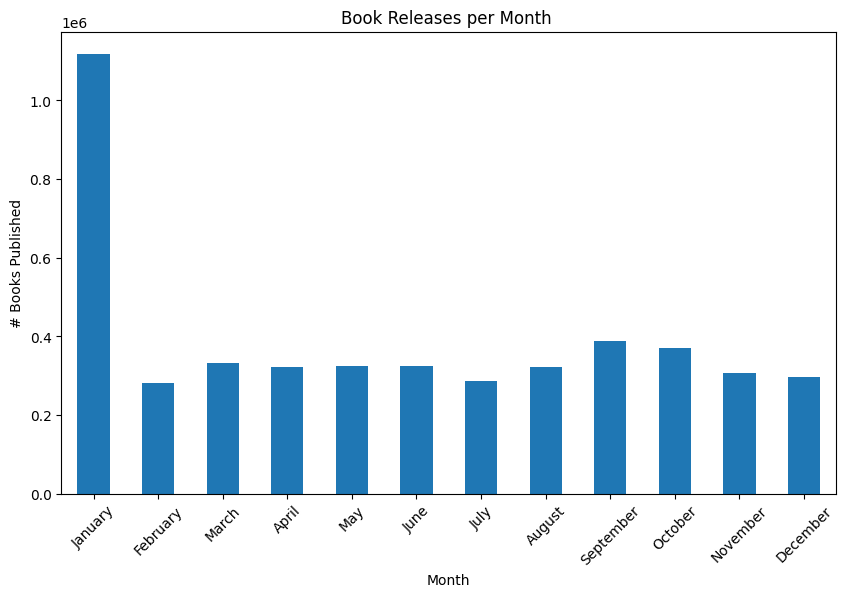

In [5]:
#RQ1

# Plotting the counts of books per month for books1
monthly_counts = books1['publication_month'].value_counts().sort_index()

# Mapping month numbers to month names
month_names = [calendar.month_name[int(month)] for month in monthly_counts.index]

# Plotting the counts of books per month with month names for books1
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar')
plt.title('Book Releases per Month ')
plt.xlabel('Month')
plt.ylabel('# Books Published')

# Setting x-axis ticks to month names
plt.xticks(range(len(month_names)), month_names, rotation=45)
plt.show()


We can also see that most books were published in january than any other month overall.

{'whiskers': [<matplotlib.lines.Line2D at 0x4aa2b8e80>,
 'caps': [<matplotlib.lines.Line2D at 0x4aa2bc400>,
 'boxes': [<matplotlib.lines.Line2D at 0x465dcfca0>],
 'medians': [<matplotlib.lines.Line2D at 0x4aa2bc940>],
 'fliers': [<matplotlib.lines.Line2D at 0x4aa2bcbe0>],
 'means': []}

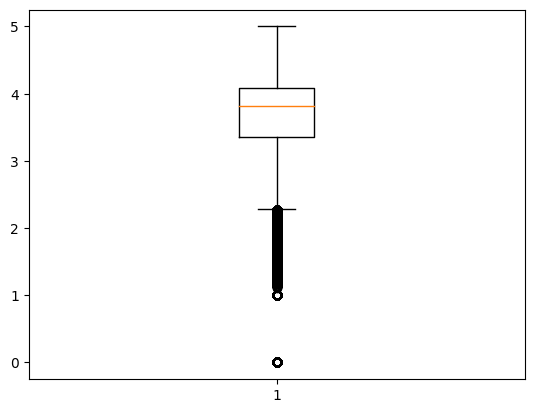

In [6]:
# BOXPLOT RATINGS RQ1
plt.boxplot(books['average_rating'] )
 

In [7]:
tempbook = books[books['average_rating'] >= 1]

In [8]:
#statistical summaries for numerical columns
numerical_columns = ['num_pages', 'ratings_count', 'average_rating']


summary = tempbook[numerical_columns].describe()

print(summary)

          num_pages  ratings_count  average_rating
count  6.017152e+06   6.017152e+06    6.017152e+06
mean   1.983644e+03   2.272571e+04    3.861296e+00
std    1.887295e+06   1.736709e+05    5.138006e-01
min    0.000000e+00   1.000000e+00    1.000000e+00
25%    0.000000e+00   1.000000e+01    3.620000e+00
50%    7.100000e+01   9.300000e+01    3.900000e+00
75%    2.640000e+02   1.286000e+03    4.130000e+00
max    2.147484e+09   7.400639e+06    5.000000e+00


In [12]:
#RQ2.1 NUM WORKS FOR AUTHORS IN DESCENDING ORDER
author_works_count = authors.groupby('name', as_index=False)['work_ids_count'].sum().reset_index()

# Sort authors by works count in descending order
sorted_authors = author_works_count.sort_values(by='work_ids_count', ascending=False)
i = 0
for index, row in sorted_authors.iterrows():
    author_name = row['name']
    works_count = row['work_ids_count']
    if works_count > 1:
        print(f"{author_name}: {works_count} books")
    else:
        print(f"{author_name}: {works_count} book")
    i+=1
    #here we will print only first 25 results for the sake of memory size
    if i>25:
        break


Brian Michael Bendis: 1530 books
Isaac Asimov: 1530 books
Chuck Dixon: 1530 books
Jim Davis: 1530 books
Roy Thomas: 1530 books
John Byrne: 1530 books
Anton Chekhov: 1530 books
Charles M. Schulz: 1530 books
Chris Claremont: 1530 books
Stan Lee: 1530 books
Enid Blyton: 1530 books
Agatha Christie: 1530 books
Peter David: 1530 books
Mark Waid: 1530 books
Robert Silverberg: 1529 books
Ray Bradbury: 1529 books
Stephen King: 1529 books
Arthur Conan Doyle: 1529 books
Reader's Digest Association: 1529 books
Walt Disney Company: 1529 books
Anonymous: 1529 books
Edgar Allan Poe: 1529 books
Osho: 1529 books
H.P. Lovecraft: 1528 books
Leo Tolstoy: 1528 books
Various: 1528 books


In [13]:
#book with the highest number of ratings RQ 2.2
book_with_highest_num_reviews = books['ratings_count'].idxmax()
book = books.loc[book_with_highest_num_reviews]['title']   
print(book)


Harry Potter und der Stein der Weisen (Harry Potter,#1)


In [14]:
#RQ 2.3
# Sort the DataFrame by 'average_score' in descending order to find the top ten books

top_ten_books = tempbook.sort_values(by='average_rating', ascending=False).head(10)
top_ten_book = top_ten_books.sort_values(by='ratings_count', ascending=False)
# Sort by 'average_score' in ascending order to find the bottom ten books
bottom_ten_books = tempbook.sort_values(by='average_rating').head(10)
bot_ten_books = bottom_ten_books.sort_values(by='ratings_count', ascending=False)
# For the books that have the same score, they are sorted by the number of total reviews in descending order
print("Books with highest scores:")
print(top_ten_book[['title', 'average_rating']])
print("\nBooks with lowest scores:")
print(bot_ten_books[['title', 'average_rating']])



Books with highest scores:
                                                     title  average_rating
3667969                                          White Oak             5.0
318798   Bratty Brothers and Selfish Sisters: All about...             5.0
5340272                        The Princess and the Popper             5.0
5340260                              Medieval Tile Designs             5.0
2877874                                         Sin Killer             5.0
1604861                                             D.N.A.             5.0
6084871                                   Jahrhundertspiel             5.0
6084876                                     Ties that bind             5.0
6084885                                      Rund der Hund             5.0
1604840  Life Application Bible: New Testament: The Liv...             5.0

Books with lowest scores:
                                                     title  average_rating
2524320                            Sensual Phr

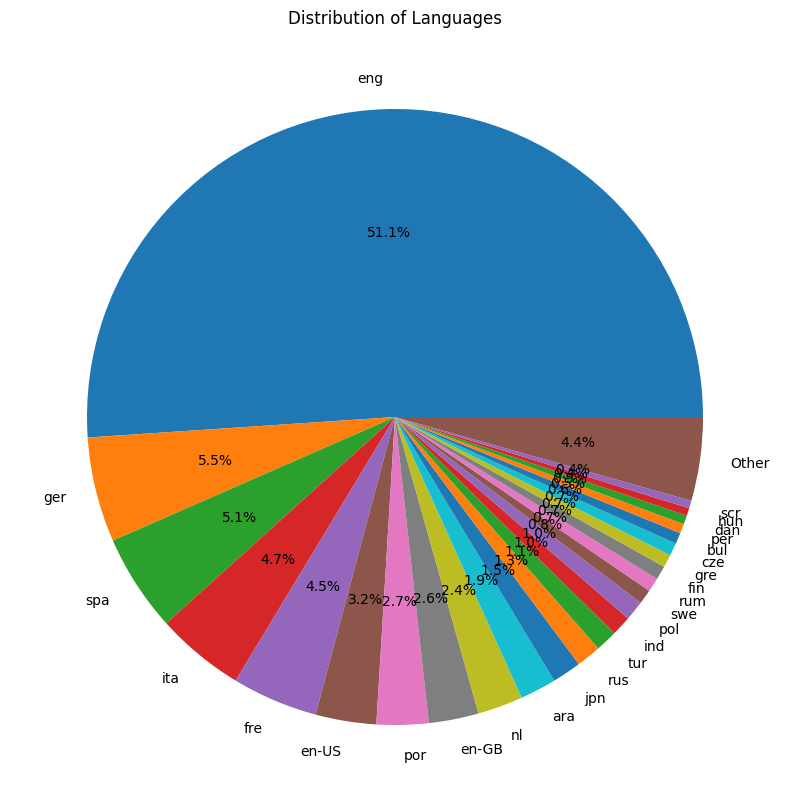

In [15]:
#RQ 2.4 plot for languages
langbooks = books.copy() # Replace empty strings with 'No Language Specified'
langbooks['language'] = langbooks['language'].replace('', 'No Language Specified')
langbooks = langbooks[langbooks['language'] != 'No Language Specified']
# Count occurrences of each language and calculate percentages
languages = langbooks['language'].value_counts()
total_count = len(langbooks)
threshold_percentage = 0.35
language_percentages = languages / total_count * 100

other_languages = language_percentages[language_percentages < threshold_percentage].sum()
top_languages = language_percentages[language_percentages >= threshold_percentage]
top_languages['Other'] = other_languages

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(top_languages, labels=top_languages.index, autopct='%1.1f%%')
plt.title('Distribution of Languages')
plt.show()

In [13]:
#RQ 2.5 BOOKS WITH NUM PAGES > 250
most_pages = books[books['num_pages'] > 250]

#here we will print only first 25 results for the sake of memory size
for title in most_pages['title'][:25]:
    print(title)


Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Harry Potter and the Chamber of Secrets (Harry Potter, #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
Harry Potter and the Goblet of Fire (Harry Potter, #4)
Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)
Harry Potter Collection (Harry Potter, #1-6)
The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy, #1-5)
The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5)
The Ultimate Hitchhiker's Guide (Hitchhiker's Guide to the Galaxy, #1-5)
A Short History of Nearly Everything
Bryson's Dictionary of Troublesome Words: A Writer's Guide to Getting It Right
In a Sunburned Country
I'm a Stranger Here Myself: Notes on Returning to America After Twenty Years Away
The Lost Continent: Travels in Small Town America
Neither Here nor There: Travels in Europe
Notes from a Small Island


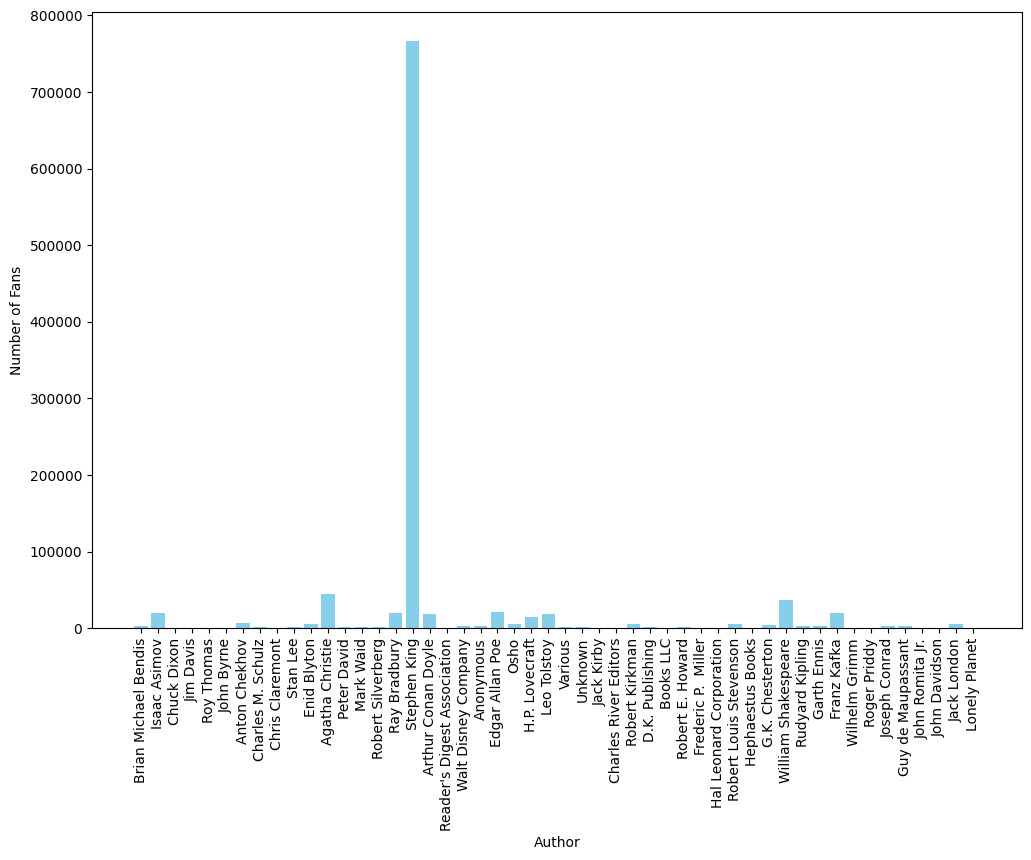

In [17]:
#RQ2.6 Fans count for top 50 authors
author_works_count = authors.groupby('name')[['work_ids_count', 'fans_count']].sum().reset_index()

# Sort authors by 'work_ids_count' in descending order
sorted_authors = author_works_count.sort_values(by='work_ids_count', ascending=False)

# Select the top 50 authors
top_50_authors = sorted_authors.head(50)

# Plot 
plt.figure(figsize=(12, 8))
plt.bar(top_50_authors['name'], top_50_authors['fans_count'], color='skyblue')
plt.xticks(rotation=90)  # Rotate the author names for readability
plt.xlabel('Author')
plt.ylabel('Number of Fans')
plt.show()


In [18]:
#RQ3 CHATGGPT
def historical_analysis(year, books):

    books1['num_pages'] = pd.to_numeric(books1['num_pages'], errors='coerce')

    books_published = books1[books1['publication_year'] == year].shape[0]  # Counting books published in the given year

    total_pages = books1[books1['publication_year'] == year]['num_pages'].sum()  # Total number of pages written in the given year

    months_count = books1[books1['publication_year'] == year]['publication_month'].value_counts().to_dict()  # Counting the books published each month in the given year

    most_prolific_month = max(months_count, key=months_count.get)  # Finding the most prolific month of the year

    longest_book = books1[books1['publication_year'] == year].nlargest(1, 'num_pages')[['title', 'num_pages']].to_dict(orient='records')[0]  # Finding the longest book written in the given year

    return {
        "books_published": books_published,
        "total_pages": total_pages,
        "most_prolific_month": most_prolific_month,
        "longest_book": longest_book
    }

# Assuming 'books1' is a Pandas DataFrame and 'year' is taken as input
year = input("Enter the year: ")
result = historical_analysis(year, books1)
print(result)


{'books_published': 110202, 'total_pages': 17699182, 'most_prolific_month': '01', 'longest_book': {'title': '21st Century Complete Guide To The National Security Agency (Nsa) With Information On Nsa Cryptology And History, Infosec Program, Computer Security Recommendation ... Initiative, World War Ii, Korean War', 'num_pages': 32080}}


In [19]:
#RQ3 my code
def historical_look(year, books1):
    #books1 is the dataset modified to make the analysis on dates
    # the function has to output:
    # a. number of books published in that year
    # b. number of pages written
    # c. most prolific month
    # d. longest written book
    

    matching_books = books1[books1['publication_year'] == year]

    if not matching_books.empty:
        print(f'Number of books published in {year} is: ')
        print(matching_books['title'].count())

        # Replace NaN values in the "num_pages" column with 0
        matching_books['num_pages'].fillna(0, inplace=True)

        # Calculate the sum of the "num_pages" column
        total_pages = matching_books['num_pages'].sum()
        print(f'Total number of pages is {total_pages}')

        # Longest written book
        sorted_by_numpages = matching_books.sort_values(by='num_pages', ascending=False)
        if not sorted_by_numpages.empty:
            bigbook = sorted_by_numpages.iloc[0]
            print(f"The longest book written is '{bigbook['title']}' with {bigbook['num_pages']} pages.")
        
        # Most prolific month
        month_counts = matching_books['publication_month'].value_counts().sort_values(ascending=False)
        
        if not month_counts.empty:
            most_prolific_month = month_counts.idxmax()
            month_name = calendar.month_name[int(most_prolific_month)]
            print(f"The most prolific month is {month_name}")
        else:
            print("No specific most prolific month available")
    else:
        print('No books were written that year in this database')

# Assuming 'books1' is a Pandas DataFrame and 'year' is taken as input
year = input("Enter the year: ")
historical_look(year, books1)

Number of books published in 2003 is: 
110202
Total number of pages is 17699182
The longest book written is '21st Century Complete Guide To The National Security Agency (Nsa) With Information On Nsa Cryptology And History, Infosec Program, Computer Security Recommendation ... Initiative, World War Ii, Korean War' with 32080 pages.
The most prolific month is January


RQ3: The only difference between my implementation and chatgpt's is the final format for the output and the transfer from the number of the month to the actual name for the month. after testing multiple inputs, both codes provide the same results for the output.

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

*  You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?
*  Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.
*  What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?
*  What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.


### 4.1
You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?


In [20]:
#RQ4.1 EPONYMOUS AUTHORS
authors['name'] = authors['name'].str.lower().str.strip()
duplicate_authors = authors['name'].value_counts()
eponymous_authors = duplicate_authors[duplicate_authors > 1]


print(f"There are {eponymous_authors.shape[0]} Authors who has 2 occurances in the dataset")
for author, occur in eponymous_authors.items():
    print(author)

There are 47 Authors who has 2 occurances in the dataset
david  nelson
robert w. sullivan iv
小野不由美
peter    green
james c.l. carson
marie-anne de la trémoille
mike   lee
julie  campbell
jean-sébastien-eugène julia de fontenelle
dimitar dimov
malcolm macfarlane
cicerón
mac
daco
caroline miller
jorge molina
hildegard von bingen
peter  davies
john  mole
yordan yovkov
boris zakhoder
brian
peter      marshall
james kent
type-moon
george  franklin
chris lynch
peter green
محمد نجيب
joseph fink
martin    shaw
john  macgregor
m.k. graff
isabella
catherine   jones
q. hayashida
paul      davies
katherine mercurio gotthardt
peter king
christopher phillips
paul graham
peter  marshall
jackson butch guice
jacques mallet du pan
erin  bedford
david yates
william messner-loebs


You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

**No this is not true, there are 47 epomymous authors in the dataset.**

In [21]:
ls_unique_dfs = []
for author, occur in eponymous_authors.items():
   ls_unique_dfs.append(authors[authors['name'] == author][:1])
temp_authors = authors.drop_duplicates(subset=['name'], keep = False) 
unique_authors = pd.concat(ls_unique_dfs, ignore_index=True)
authors = pd.concat([temp_authors, unique_authors], ignore_index=True)

In [22]:
authors.shape

(351689, 13)

### 4.2

Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.


In [24]:
def author_books(author_ids):
    author_books_titles = {}
    for id in tqdm(author_ids):
        author_books_titles[id] = list(set(books[books['author_id'] == id]['title'].values))
    return author_books_titles
    

In [25]:
top_authors_ids = authors.sort_values('average_rating', ascending=False)[:20]['id'].values
author_books_titles = author_books(top_authors_ids)

all_titles = []
for author, titles in author_books_titles.items():
    all_titles.extend(titles)

100%|██████████| 20/20 [00:00<00:00, 194.76it/s]


In [26]:
author_books_titles

{17652621: ['A Latin grammar, compiled from the Roman classics and adapted to teaching by termination'],
 20731399: [],
 17328978: [],
 7233166: ['The Red Hot Grind Show'],
 20017235: [],
 20017150: [],
 7232974: ['The Wall Around the World and Other Science Fiction Stories'],
 20729924: [],
 1991748: ['Paki Waitara', 'Manawa Hine: Women Who Swam Against the Tide'],
 20731310: ['Till Human Voices Wake Us'],
 14610738: [],
 20731895: [],
 20723567: [],
 14611661: [],
 7232273: ['الخصال المكفرة للذنوب',
  'تفسير الخطيب الشربيني - السراج المنير في الإعانة على معرفة بعض معاني كلام ربنا الحكيم الخبير'],
 20732149: [],
 17316951: [],
 20733063: [],
 18768079: [],
 20733122: []}

In [27]:
len_all_titles = {}
for title in all_titles:
    len_all_titles[title] = len(title)
    
sorted_len_d = sorted(len_all_titles.items(), key = lambda x: -x[1])
long_title = sorted_len_d[0]
small_title = sorted_len_d[-1]

### 4.3

What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?


In [28]:
print(long_title)
print(small_title)

('تفسير الخطيب الشربيني - السراج المنير في الإعانة على معرفة بعض معاني كلام ربنا الحكيم الخبير', 92)
('Paki Waitara', 12)


In [29]:
total_titles = list(set(books['title'].values))
total_titles.sort()
total_len_d = {}
for title in total_titles:
    total_len_d[title] = len(title)

sorted_total_len_d = sorted(total_len_d.items(), key = lambda x: -x[1])
total_long_title = sorted_total_len_d[0]
total_small_title = sorted_total_len_d[-2]

In [30]:
#RQ4.3 
print(total_long_title)
print(total_small_title)

('(� 695 Bis 1084): Aus: Grundri� Der Vergleichenden Grammatik Der Indogermanischen Sprachen: Kurzgefa�te Darstellung Der Geschichte Des Altindischen, Altiranischen (Avestischen U. Altpersischen), Altarmenischen, Altgriechischen, Albanesischen, Lateinisc...', 255)
('혀', 1)


What is the longest book title among the books of the top 20 authors regarding their average rating? 

**Longest Title** is: 'تفسير الخطيب الشربيني - السراج المنير في الإعانة على معرفة بعض معاني كلام ربنا الحكيم الخبير', **92 characters**


Is it the longest book title overall?
**No** The longest title overall: '(� 695 Bis 1084): Aus: Grundri� Der Vergleichenden Grammatik Der Indogermanischen Sprachen: Kurzgefa�te Darstellung Der Geschichte Des Altindischen, Altiranischen (Avestischen U. Altpersischen), Altarmenischen, Altgriechischen, Albanesischen, Lateinisc...', **255 characters**





### 4.4

What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

The shortest book title overall is: "혀", **1 character**

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

*  Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

*  Have they published any series of books? If any, extract the longest series name among these authors.

*  How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

*  Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

### 5.1

Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?


In [31]:
def upper_first_letter(title):
    title = title.split(' ')
    title = [word.capitalize() for word in title]
    return ' '.join(title)
authors['name'] = authors['name'].apply(upper_first_letter)
authors['books_count'] = authors['book_ids'].apply(lambda x: len(x))
authors.sort_values('fans_count', ascending=False)[['name', 'fans_count', 'books_count']].head(10)

,name,fans_count,books_count
1017,Stephen King,766035,1529
169332,Veronica Roth,455358,57
6395,Bill Gates,446876,12
205802,Colleen Hoover,356633,57
4536,Rick Riordan,339346,172
1161,James Patterson,317040,747
100144,John Green,282537,57
3817,Neil Degrasse Tyson,277850,52
27099,Cassandra Clare,238560,203
32346,Mindy Kaling,234647,16


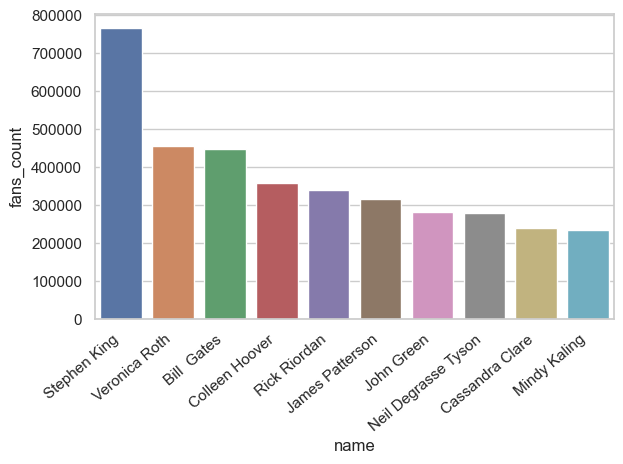

In [32]:
sns.set(style="whitegrid")
ax = sns.barplot(x="name", y="fans_count", data=authors.sort_values('fans_count', ascending=False)[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

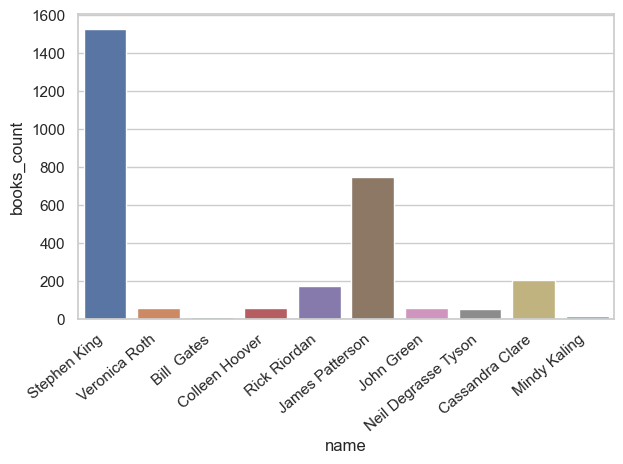

In [33]:
sns.set(style="whitegrid")
ax = sns.barplot(x="name", y="books_count", data=authors.sort_values('fans_count', ascending=False)[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Answer**: Analyzing the graphs above, we can confidently say that Stephen King is the most influential author


### 5.2
Have they published any series of books? If any, extract the longest series name among these authors.


In [34]:
top10_authors = authors.sort_values('fans_count', ascending=False)[['name', 'id', 'fans_count', 'books_count']].head(10)

In [35]:
top10_authors

,name,id,fans_count,books_count
1017,Stephen King,3389,766035,1529
169332,Veronica Roth,4039811,455358,57
6395,Bill Gates,23470,446876,12
205802,Colleen Hoover,5430144,356633,57
4536,Rick Riordan,15872,339346,172
1161,James Patterson,3780,317040,747
100144,John Green,1406384,282537,57
3817,Neil Degrasse Tyson,12855,277850,52
27099,Cassandra Clare,150038,238560,203
32346,Mindy Kaling,194416,234647,16


In [36]:
series = {}
for id in top10_authors.id.values:
    author = top10_authors[top10_authors['id'] == id].name.values[0]
    series[author] = list(set(books[books.author_id == id]['series_name'].dropna().values))

In [37]:
def longest_string(d):
    max_len = 0
    max_str = ''
    for key, values in d.items():
        for series in values:
            if len(series) > max_len:
                longest_series = series
                max_len = len(longest_series)
                author = key
    print(f'Author: {author}, Series: {longest_series}, Length: {max_len}')

longest_string(series)

Author: Rick Riordan, Series: Percy Jackson and the Olympians: The Graphic Novels, Length: 51


**Answer**: Author: Rick Riordan, Series: Percy Jackson and the Olympians: The Graphic Novels, Length: 51

### 5.3
How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

In [38]:
formats = {}
for id in top10_authors.id.values:
    author = top10_authors[top10_authors['id'] == id].name.values[0]
    formats[author] = list(set(books[books.author_id == id]['format'].dropna().values))

In [39]:
import collections
formats_list = []
for author, format in formats.items():
        formats_list.extend(format)

c = collections.Counter(formats_list)

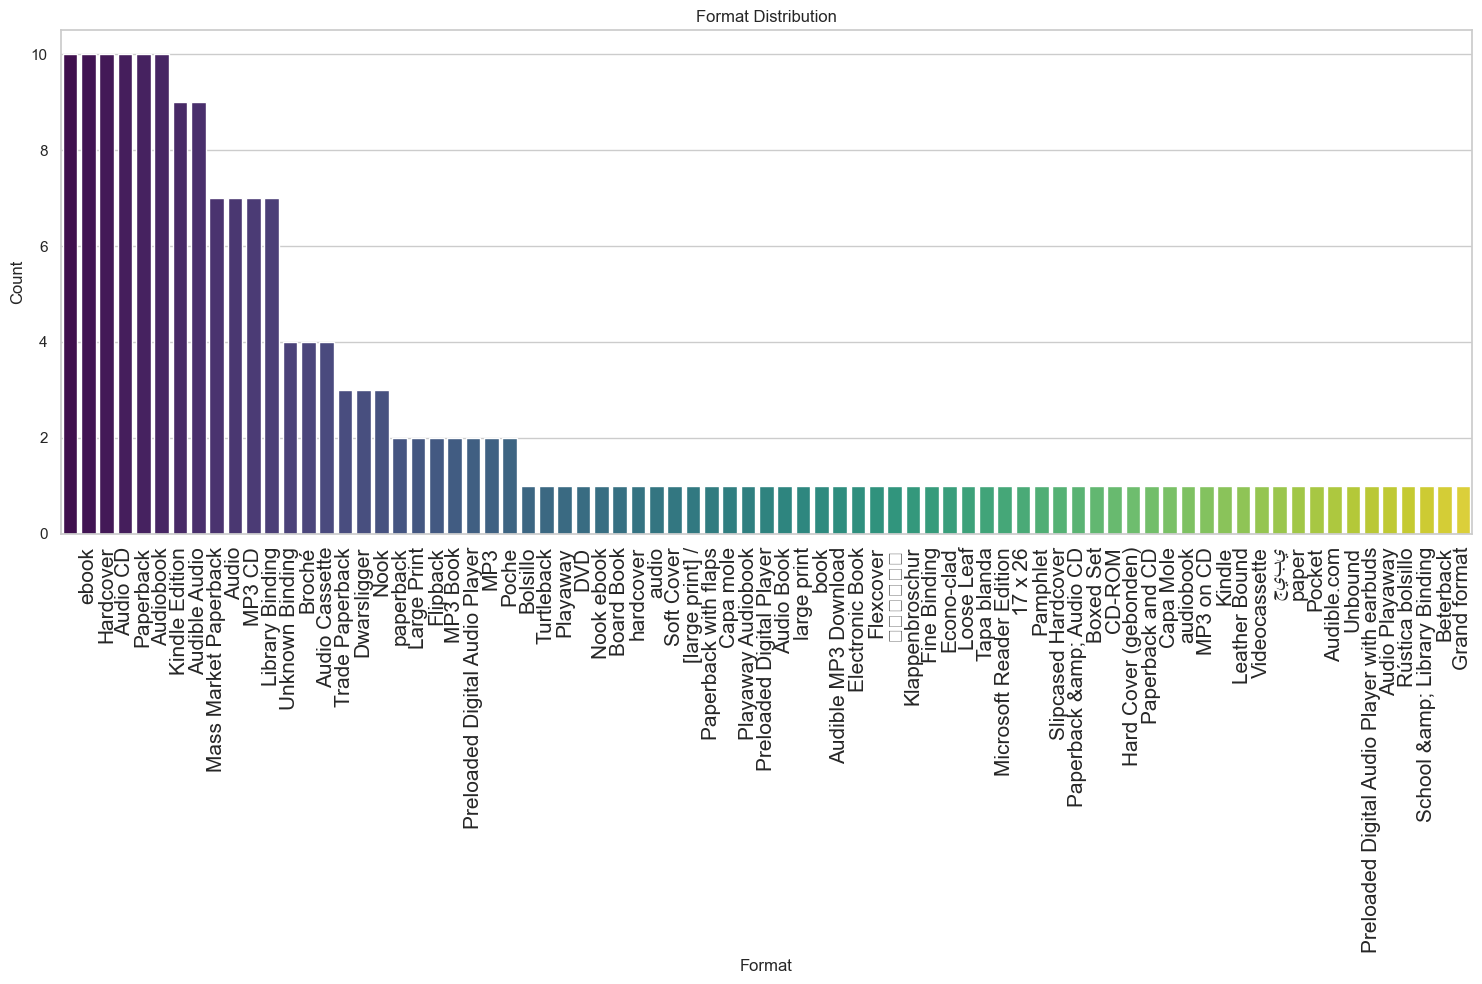

In [40]:
data = {'Format': list(c.keys()), 'Count': list(c.values())}
df = pd.DataFrame(data)
df = df.sort_values('Count', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.barplot(x="Format", y="Count", data=df, palette="viridis")
plt.title("Format Distribution")
plt.xlabel("Format")
plt.ylabel("Count")
plt.xticks(rotation=90, fontsize = 15 )
plt.tight_layout()

**Answer:** We can note on the graph, that the most influential authors have been published in different formats. The most common format is ebook, Paperback, Audio CD, Hardcover, Audiobook, Paperback. The least common format is related to Audio formats.

### 5.4
Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

In [41]:
authors = authors.dropna(subset=['gender'])
majorities = authors[(authors['gender'] == 'male') | (authors['gender'] == 'female')]
unknown =  authors[authors['gender'] != '']

In [42]:
unknown.shape

(351689, 14)

In [43]:
majorities.groupby('gender').count()['id']

gender
female    109863
male      138151
Name: id, dtype: int64

In [44]:
stats = majorities.groupby('gender').aggregate({'average_rating': 'mean', 'ratings_count': 'mean', 'text_reviews_count': 'mean', 'fans_count': 'mean'})
stats

,average_rating,ratings_count,text_reviews_count,fans_count
gender,,,,
female,3.840313,6501.571785,507.062168,180.635555
male,3.606794,5368.094838,303.915071,95.817041


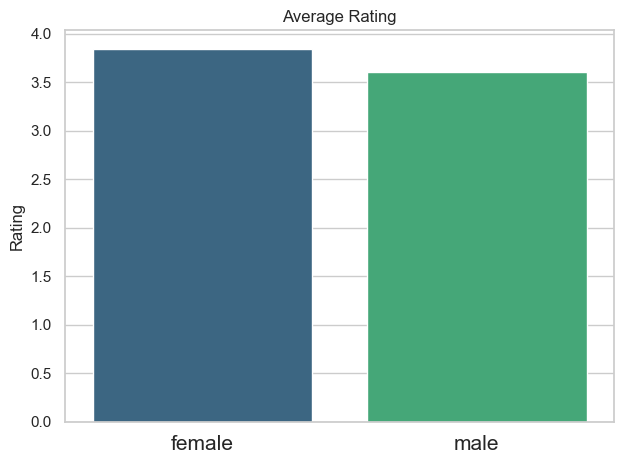

In [45]:
sns.set(style="whitegrid")
sns.barplot(x = stats.index, y = stats['average_rating'], palette="viridis")
plt.title("Average Rating")
plt.xlabel("")
plt.ylabel("Rating")
plt.xticks(rotation=0, fontsize = 15 )
plt.tight_layout()

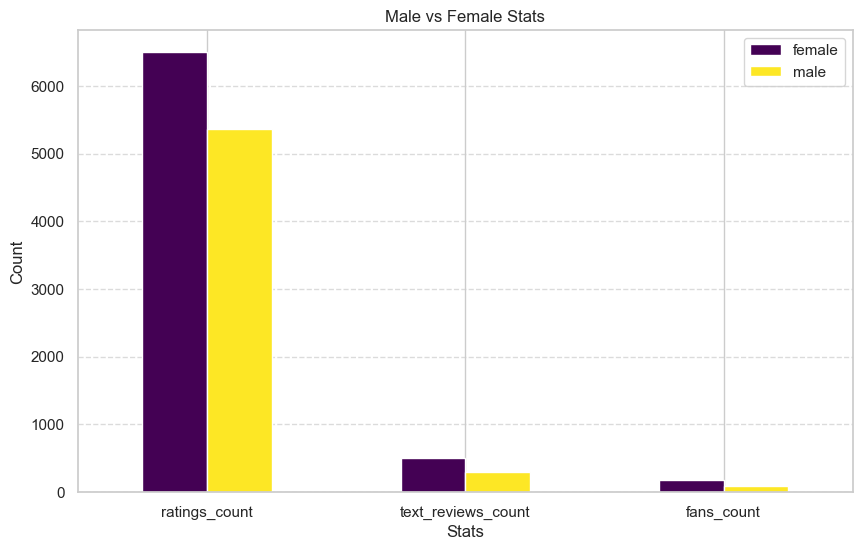

In [46]:
stats_T = stats[['ratings_count', 'text_reviews_count', 'fans_count']].transpose()
ax = stats_T.plot(kind='bar', rot=0, colormap="viridis", figsize=(10, 6))
plt.title("Male vs Female Stats")
plt.xlabel("Stats")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Here, we can claim that female authors are slightly more popular than male authors. However the data is not balanced as there is difference in count size between male and female authors. Also, we should say that there are 248373 authors with unknown genders, and this is huge number that can affect the results.

We can do downsampling to balance the data. And see what results we will get.

In [47]:
males = authors[authors['gender'] == 'male']
females = authors[authors['gender'] == 'female']
males_sample = males.sample(females.shape[0], random_state=42)
sampled_data = pd.concat([females, males_sample], axis = 0)
stats_2 = sampled_data.groupby('gender').aggregate({'average_rating': 'mean', 'ratings_count': 'mean', 'text_reviews_count': 'mean', 'fans_count': 'mean'})
stats_2

,average_rating,ratings_count,text_reviews_count,fans_count
gender,,,,
female,3.840313,6501.571785,507.062168,180.635555
male,3.605688,5111.434569,294.371444,89.222641


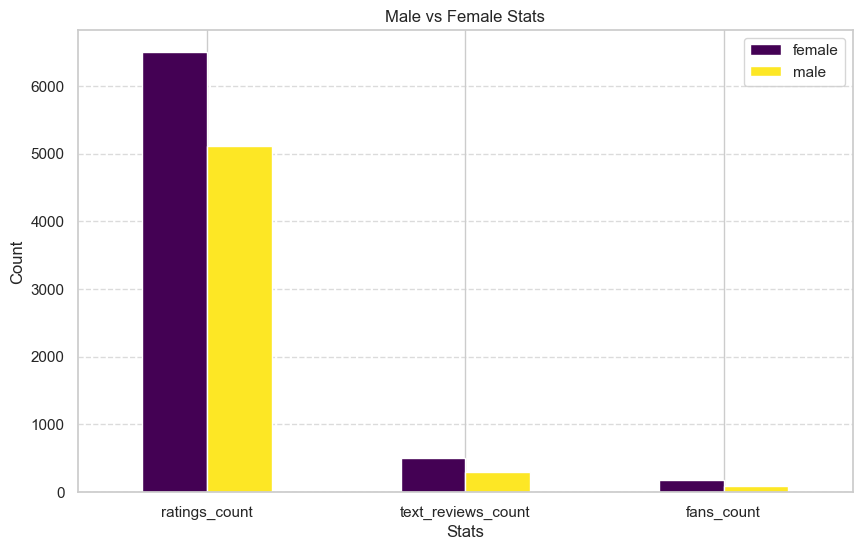

In [48]:
stats_T_2 = stats_2[['ratings_count', 'text_reviews_count', 'fans_count']].transpose()
ax = stats_T_2.plot(kind='bar', rot=0, colormap="viridis", figsize=(10, 6))
plt.title("Male vs Female Stats")
plt.xlabel("Stats")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Even after we balanced the data, the main trends of male and female authors on researched metrics still remained the same.
Female authors are slightly more popular than male authors.

In [49]:
minorities = authors[~((authors['gender'] == 'male') | (authors['gender'] == 'female'))]
minorities = minorities[minorities['gender'] != '']
minorities.shape

(103675, 14)

In [50]:
minor_stats = minorities.describe().iloc[1, :]

In [51]:
minor_stats = pd.DataFrame(minor_stats).transpose()[['average_rating', 'ratings_count', 'text_reviews_count', 'fans_count']]
minor_stats.set_index(pd.Index(['Minorities']), inplace=True)
total_stats = pd.concat([stats, minor_stats], axis = 0)
total_stats

,average_rating,ratings_count,text_reviews_count,fans_count
female,3.840313,6501.571785,507.062168,180.635555
male,3.606794,5368.094838,303.915071,95.817041
Minorities,3.510561,2142.052317,180.598640,59.546641


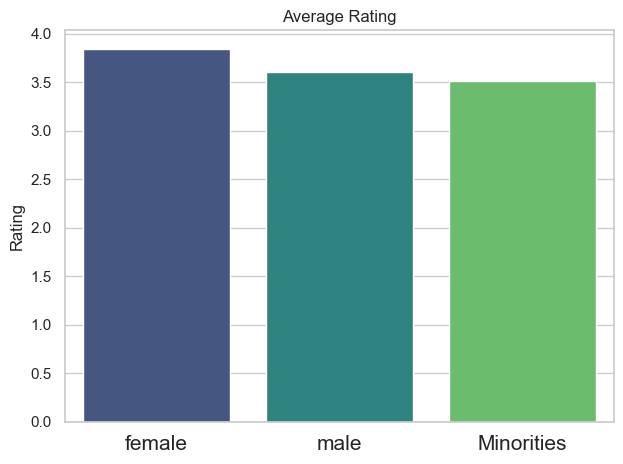

In [52]:
sns.set(style="whitegrid")
sns.barplot(x = total_stats.index, y = total_stats['average_rating'], palette="viridis")
plt.title("Average Rating")
plt.xlabel("")
plt.ylabel("Rating")
plt.xticks(rotation=0, fontsize = 15 )
plt.tight_layout()

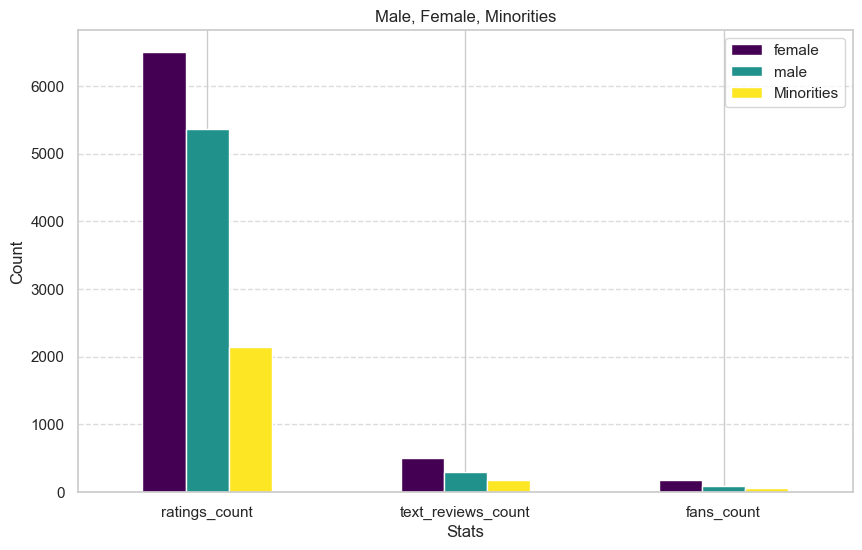

In [53]:
total_stats_T = total_stats[['ratings_count', 'text_reviews_count', 'fans_count']].transpose()
ax = total_stats_T.plot(kind='bar', rot=0, colormap="viridis", figsize=(10, 6))
plt.title("Male, Female, Minorities")
plt.xlabel("Stats")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

It can be noticed, that Minorities almost the same average rating with male(slightly lower). But again the data is not balanced, and the count size of minorities is extremely small (333), so we can't make any conclusions and be confident in them.

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

*  Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?
*  For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

### 6.1 
Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

I expect to see that the average time gap between two subsequent publications for a series of books is lower than for those not belonging to a series. Because, when author writes a series of books, there is a plan of how many books he/she will write and when to publish them. But when author writes books that don't belong to a series, there is no plan and author writes books with different time gaps.

In [54]:
top10_authors = authors.sort_values('fans_count', ascending=False).head(10)

In [55]:
def pub_data(date):
    date = str(date)
    if len(date) == 4:
        date = date + '-01-01'
    elif len(date) == 7:
        date = date +  '-01'
    elif len(date) != 10:
        return None
    return date

In [56]:
books['publication_date'] = books['publication_date'].apply(lambda x: pub_data(x))

In [57]:
def timedelta_to_years(delta: datetime.timedelta) -> float:
        seconds_in_year = 365.25*24*60*60
        return delta.total_seconds() / seconds_in_year

In [58]:
def series_time_gap(author_id: int):
    books_author = books[(books['author_id'] == author_id) & 
                        (books['format'] == 'Hardcover') & 
                        (books['language'] == 'eng')].copy()

    books_author = books_author.drop_duplicates(subset=['title'], keep='first')
    books_author = books_author.dropna(subset=['publication_date'])
    books_author_series = books_author[(books_author['series_name'].notna()) & (books_author['series_position'] != '')]
    series = books_author_series['series_name'].unique()

    if len(series) == 0:
        return None
    df_series = []
    
    for serie in series:
        books_author_serie = books_author_series[books_author_series['series_name'] == serie].copy()
        books_author_serie['publication_date'] = pd.to_datetime(books_author_serie['publication_date'], format='%Y-%m-%d')
        books_author_serie = books_author_serie.sort_values('publication_date', ascending=True)

        books_author_serie = books_author_serie.drop_duplicates(subset=['series_position'], keep='first')

        books_author_serie['time_gap'] = books_author_serie.groupby('series_name')['publication_date'].diff()
        

        books_author_serie = books_author_serie.dropna(subset = ['time_gap'])
        books_author_serie = books_author_serie[books_author_serie['time_gap'] != '0 days']
        df_series.append(books_author_serie)

    result_df = pd.concat(df_series, axis=0, ignore_index=True)

    if result_df.shape[0] == 0:
        return None

    mean_time_gap = result_df['time_gap'].mean()
    years_mean = timedelta_to_years(mean_time_gap)
    return round(years_mean, 2)

In [59]:
def not_series_time_gap(author_id: int):
    books_author = books[(books['author_id'] == author_id) & 
                        (books['format'] == 'Hardcover') & 
                        (books['language'] == 'eng')].copy()
    

    books_author = books_author.drop_duplicates(subset=['title'], keep='first')

    books_author = books_author.dropna(subset=['publication_date'])


    books_not_in_series = books_author[(books_author['series_name'].isna()) | (books_author['series_name'] == '')].copy()

    books_not_in_series['publication_date'] = pd.to_datetime(books_not_in_series['publication_date'], format='%Y-%m-%d')
    books_not_in_series = books_not_in_series.sort_values('publication_date', ascending=True)

    books_not_in_series['time_gap'] = books_not_in_series['publication_date'].diff()

    books_not_in_series = books_not_in_series.dropna(subset=['time_gap'])
    books_not_in_series = books_not_in_series[books_not_in_series['time_gap'] != '0 days']

    if books_not_in_series.shape[0] == 0:
        return None

    mean_time_gap = books_not_in_series['time_gap'].mean()
    years_mean = timedelta_to_years(mean_time_gap)
    return round(years_mean, 2)

not_series_time_gap(3389)

0.61

In [60]:
total_time_gap = {}
for id in tqdm(top10_authors.id.values):
    name = top10_authors[top10_authors['id'] == id].name.values[0]
    total_time_gap[name] = [series_time_gap(id), not_series_time_gap(id)]

100%|██████████| 10/10 [02:48<00:00, 16.88s/it]


In [61]:
total_time_gap_df = pd.DataFrame(total_time_gap).transpose().rename(columns={0: 'Series', 1: 'Not in Series'})
total_time_gap_df

,Series,Not in Series
Stephen King,6.53,0.61
Veronica Roth,0.80,NaN
Bill Gates,NaN,3.25
Colleen Hoover,NaN,0.23
Rick Riordan,1.01,NaN
James Patterson,1.14,0.99
John Green,NaN,2.10
Neil Degrasse Tyson,NaN,4.06
Cassandra Clare,1.32,NaN
Mindy Kaling,NaN,3.87


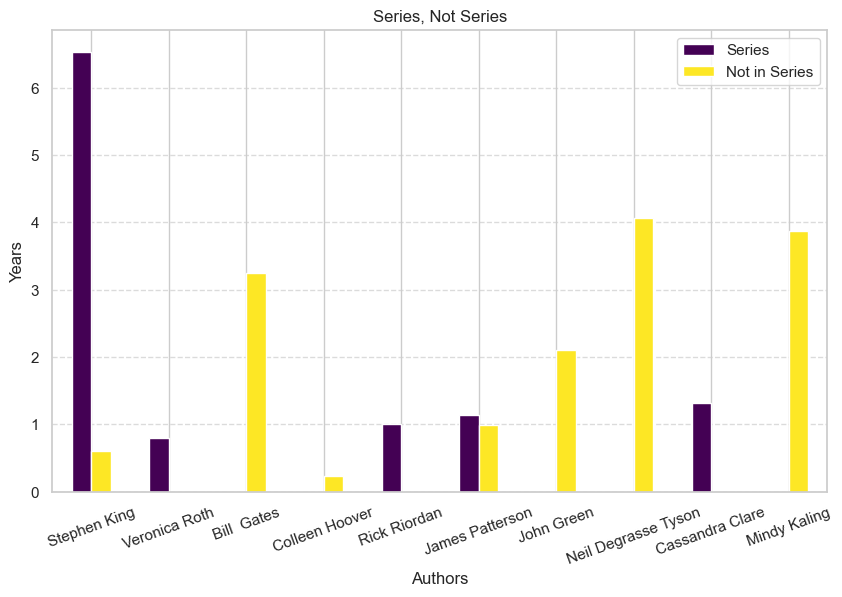

In [62]:
ax = total_time_gap_df.plot(kind='bar', rot=20, colormap="viridis", figsize=(10, 6))
plt.title("Series, Not Series")
plt.xlabel("Authors")
plt.ylabel("Years")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
total_series_mean = total_time_gap_df['Series'].mean()
total_not_series_mean = total_time_gap_df['Not in Series'].mean()

print(f'Total series time gap mean(years): {round(total_series_mean, 3)}' + '\n' + f'Total not series time gap mean(years): {round(total_not_series_mean, 3)}')


Total series time gap mean(years): 2.16
Total not series time gap mean(years): 2.159


We can say that the mean time gap for both series books and not series book are the almost the same.

There are too many Nones in the dataset, so we can't make any conclusions about the average time gap between two subsequent publications for a series of books and those not belonging to a series for top 10 authors. These None values means that some authors don'h have any series of books or books that are not part of a series. Also, it can be that some books were filtered out during the data cleaning process, as they have inappropriate values in the publication year column.


However, for better understanding of the data, we can take only those authors who have series of books and books that are not part of a series.

In [64]:
top40_authors = authors.sort_values('fans_count', ascending=False).head(40)

In [65]:
total_time_gap_40 = {}
for id in tqdm(top40_authors.id.values):
    name = top40_authors[top40_authors['id'] == id].name.values[0]
    total_time_gap_40[name] = [series_time_gap(id), not_series_time_gap(id)]

total_time_gap_40

100%|██████████| 40/40 [11:46<00:00, 17.67s/it]


{'Stephen King': [6.53, 0.61],
 'Veronica Roth': [0.8, None],
 'Bill  Gates': [None, 3.25],
 'Colleen Hoover': [None, 0.23],
 'Rick Riordan': [1.01, None],
 'James Patterson': [1.14, 0.99],
 'John Green': [None, 2.1],
 'Neil Degrasse Tyson': [None, 4.06],
 'Cassandra Clare': [1.32, None],
 'Mindy Kaling': [None, 3.87],
 'Patrick Rothfuss': [2.86, None],
 'J.k. Rowling': [0.86, 5.76],
 'Nicholas Sparks': [4.91, 1.27],
 'Diana Gabaldon': [4.23, None],
 'Sarah J. Maas': [0.77, None],
 'Wil Wheaton': [None, None],
 'Brandon Sanderson': [2.27, 4.5],
 'Maggie Stiefvater': [1.67, None],
 'Kristin Hannah': [None, 1.77],
 'Khaled Hosseini': [None, 2.99],
 'Rainbow Rowell': [None, 0.45],
 'Felicia Day': [None, 2.04],
 'Roxane Gay': [None, 0.31],
 'Chuck Palahniuk': [1.97, 1.62],
 'Marie Lu': [0.98, None],
 'Paulo Coelho': [2.38, 1.28],
 'Lauren Oliver': [1.04, 1.72],
 'Sylvia Day': [0.48, None],
 'David Baldacci': [1.58, 1.96],
 'L.j. Smith': [2.65, None],
 'Marissa Meyer': [0.96, None],
 'Mitch

In [66]:
total_time_gap_40_df = pd.DataFrame(total_time_gap_40).transpose().rename(columns={0: 'Series', 1: 'Not in Series'})

total_time_gap_40_df.dropna(inplace=True)

In [67]:
total_time_gap_10_df = total_time_gap_40_df[:10]

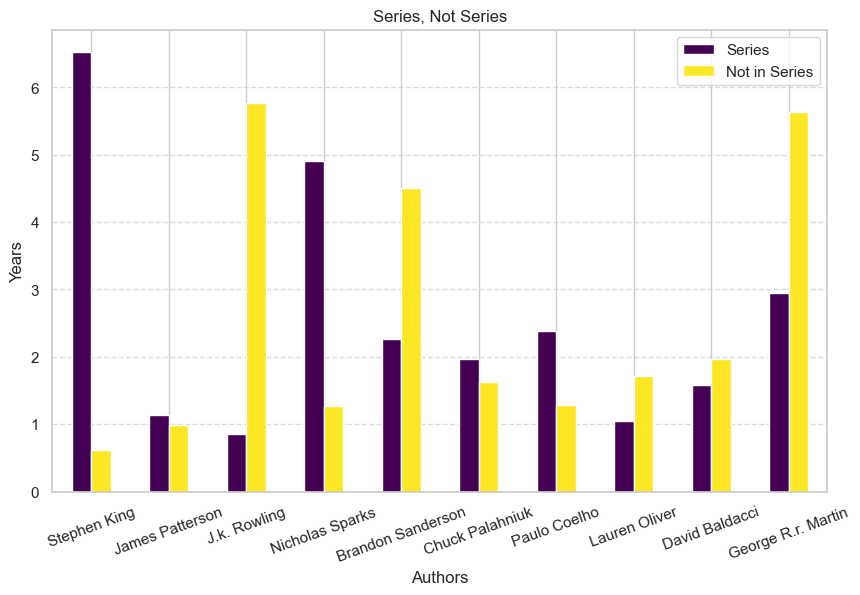

In [68]:
ax = total_time_gap_10_df.plot(kind='bar', rot=20, colormap="viridis", figsize=(10, 6))
plt.title("Series, Not Series")
plt.xlabel("Authors")
plt.ylabel("Years")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [69]:
total_series_mean = total_time_gap_10_df[1:]['Series'].mean()
total_not_series_mean = total_time_gap_10_df[1:]['Not in Series'].mean()

print(f'Total series time gap mean(years): {round(total_series_mean, 3)}' + '\n' + f'Total not series time gap mean(years): {round(total_not_series_mean,3)}')


Total series time gap mean(years): 2.121
Total not series time gap mean(years): 2.748


Here we can see that  the mean time gap for series books is slightly higher than for not series books and  our expectations were wrong. However, Stephen King has the highest mean time gap for series books, and this is the reason why the mean time gap for series books is higher than for not series books.If we will remove Stephen King from the dataset, we will see that the mean time gap for series books is lower than mean time gap for not series books.

As we expected, removing Stephen King from the dataset, we can see that the mean time gap for series books is lower than mean time gap for not series books. So partially our expectations were right.

### 6.2
For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [72]:
def plot_books_published(author_id):
    books_author = books[(books['author_id'] == author_id) & 
                        (books['format'] == 'Hardcover') & 
                        (books['language'] == 'eng')].copy()

    books_author = books_author.drop_duplicates(subset=['title'], keep='first')

    books_author = books_author.dropna(subset=['publication_date'])

    books_author['publication_date'] = pd.to_datetime(books_author['publication_date'], format='%Y-%m-%d')
    books_author = books_author.sort_values('publication_date', ascending=True)

    books_author['year'] = books_author['publication_date'].dt.year

    books_author['year'].value_counts().sort_index().plot(kind='bar', rot=45, colormap="viridis", figsize=(10, 6))
    plt.title(f"{books_author.author_name.values[0]}:Books Published")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [ ]:
for id in tqdm(top10_authors.id.values):
    plot_books_published(id)

We can notice that the authors are not contemporary with each other. The production rate of each author is different. Stephen King has the highest production rate, and he has published more than 100 books. The production rate of other authors is much lower. Also, we can notice that the production rate for Rick Riordan and James Patterson started to increase every year after 2009. Authors like Mindy Kalling, Neil DeGrasse Tyson and Bill Gates have a large time gap in their production rate and these authors with Colleen Hoover have published less than 5 books. Cassandra Clare has a spike in her production rate between 2011 and 2014, and after 2014 her production rate stayed as 1 book per year. Overall, we can say that the production rate of authors is different and it depends on the author.

In [73]:

#RQ 7.1
books['rati_dist']=books['rating_dist'].str.split('|')
books['rati_dist']=books['rating_dist'].str.split('|')
p=0
q=0
for i in range (len(books['rati_dist'])):
  n5=books['rati_dist'][i][0]
  #n4=books['rati_dist'][i][1]
  n5=int(n5[2:])
  #n4=int(n4[2:])
  q+=1
  ntot=int(books['ratings_count'][i])
  if ntot!=0 and n5/ntot>=0.3:
    p+=1
p=p/q
print(p)
#p=53.76%
#p=53.76%

0.45015554048129397


In [79]:
unique_authors = pd.unique(books1['author_id'])
author_years = {}

for author_id in unique_authors:
    years = books1[books1['author_id'] == author_id]['publication_year'].values
    if len(years) > 0:
        author_years[author_id] = years[-1]

# Create NumPy array 'a' from the dictionary values
a = np.array([author_years.get(author, np.nan) for author in unique_authors])
b = 0
for author_id in unique_authors:
    b += len(author_years[author_id])
print(b)

c = 0
for author_id in unique_authors:
    for j in range(len(author_years[author_id])-1):
        if int(author_years[author_id][j+1]) - int(author_years[author_id][j]) <= 2:
            c +=1

print(c/b)

967404
0.5902632199163949


In [84]:
lista = pd.read_json('../list.json', lines=True, nrows=1)
list_id = lista['id'].tolist()

# Assuming 'books' is a DataFrame containing 'id' and 'num_pages' columns
# Make sure the 'books' DataFrame is appropriately loaded before running this code

numpg = []
d = 0

# Check if the 'id' values exist in the 'books' DataFrame and collect 'num_pages' for the valid 'id's
for i in range(len(list_id)):
    if books['id'].isin([int(list_id[i])]).any():
        num_pages = books.loc[books['id'] == int(list_id[i]), 'num_pages'].to_string(index=False)
        if num_pages.isdigit():
            d += 1
            numpg.append(int(num_pages))

  # d = number of books in the list with a valid amount of pages

a = sum(1 for pages in numpg if pages > 700)
 # a = number of books in the list with more than 700 pages

# Calculating conditional probabilities
e = sum(1 for page in books['num_pages'] if str(page).isdigit())
f = sum(1 for page in books['num_pages'] if str(page).isdigit() and page > 700)

p_y = f / e  # p(Y)
p_xy = a / e  # p(X,Y)
p_x_given_y = a / f  # p(X|Y)

# Results
print(a / d, f / e)
print((f / e) * (d / e))
print(p_x_given_y)


#p(Y|X)=0.05243055555555556!=#p(Y)=0.03434803473284862

#p(Y)*p(X)=0.0004478434125775469
#p(Y)*p(X)!=p(X,Y)
#not independent

1.0 0.015906231090767043
2.407400733737574e-09
9.515109994671538e-06


In [97]:
books['num_pages'][36]

288

In [101]:
#RQ 8.1
from scipy.stats import pearsonr

npgs = []
avrt = []

for row in tqdm(books.itertuples()):
    if str(row.num_pages).isdigit():
        npgs.append(row.num_pages)
        avrt.append(row.average_rating)

r_xy, p_value = pearsonr(avrt, npgs)
print(r_xy)
#the p-value is bigger than 0.05, so we don't have sufficient evidence to reject the null hypotesis,which is that the number of pages and
#average rating of the books are uncorrelated, or positivly correlated (since the alternative is less) and we can't say that people usually
#rate worse books withalotofpages

0it [00:00, ?it/s]

6607222it [00:28, 232727.94it/s]


0.0002529781694947567


0.21610078357328055 1408146


KstestResult(statistic=0.00013250888553147837, pvalue=0.9789540645103171, statistic_location=1.45, statistic_sign=1)

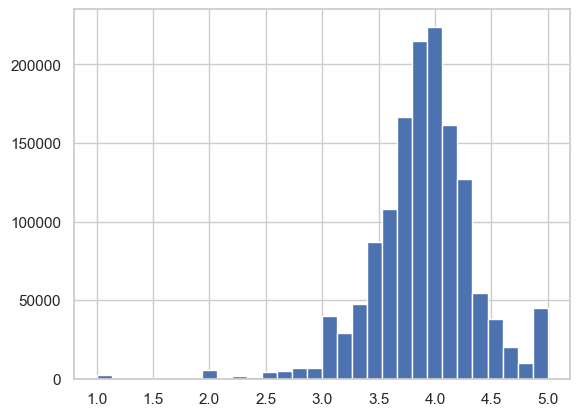

In [102]:
#RQ8.2
from scipy.stats import normaltest
from scipy.stats import kstest
books=books[(books['average_rating']>0)]
books_eng=books[(books['language']=='eng')|(books['language']=='en-US')|(books['language']=='en-GB')|(books['language']=='US') ]

books_oth=books[(books['language']!='eng')&(books['language']!='en-US')&(books['language']!='')&(books['language']!='en-GB')&(books['language']!='US')]
plt.hist(books_eng['average_rating'],bins=30)
print(np.var(books_eng['average_rating']),len((books_eng['average_rating'])))
normaltest(books_eng['average_rating'])
#The two histogram seems similar, unfortunatly neither of the distribution passes a normal test, so we are not going to be able
#to use a t-test or a z-test to compare the two distributions.
#More unfortunatly the variances are different, and while it's consider acceptable if the largest dataset's variance
#is greater that the other one in this case we have the opposite: the dataset of english books it's bigger and has less variance
#than the other one (which is not surprising considering that the dataset with all the other language is obviusly less homogeneus),
#for this reason we can't use a Mann-Whitney or a Kruskal-Wills test (non-parametric tests based on the median) that need the two distributions to be homoschedatic.
#so to compare the two distributions we can use the Kolmogorov-Smirnov test
kstest(books_eng['average_rating'],books_oth['average_rating'],alternative='greater')

#the p-value it's less than 0.05 so we have to reject the null hypotesis that the two distributions come from the same population

count    1.408146e+06
mean     3.893028e+00
std      4.648666e-01
min      1.000000e+00
25%      3.670000e+00
50%      3.920000e+00
75%      4.140000e+00
max      5.000000e+00
Name: average_rating, dtype: float64

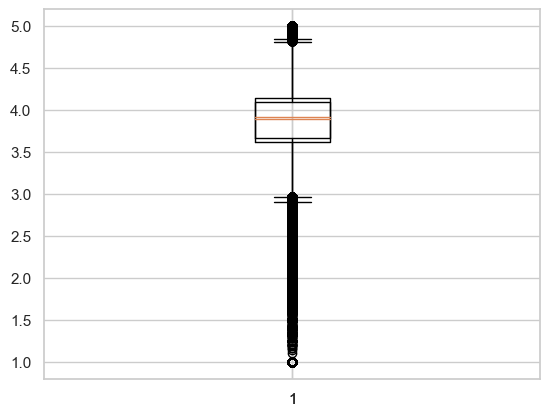

In [103]:
#RQ8.3

plt.boxplot(books_oth['average_rating'])
books_oth['average_rating'].describe()
#in the boxplot the box goes from the 25th percentile(first quartile) to the 75th percentile(tthird quartile) while the orange line is
#the median. The two horizontal lines are where the max and the min are located (excluding the outliers, the boxplot consider every value
#below q_0.25-1.5*(q_0.75-q_0.25) or above q_0.75+1.5*(q_0.75-q_0.25) as outliers)
plt.boxplot(books_eng['average_rating'])
books_eng['average_rating'].describe()
#judging by the mean and quantile the two distributions seem pretty similar but as said before the variance is quite different considering
#that the way smaller dataset of non-english books has more variance

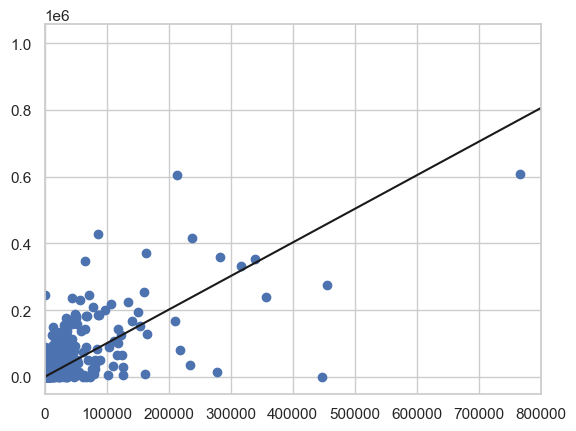

218.6831961202725 1.006438511294867


In [104]:
#RQ8.4
b, a = np.polyfit(authors['fans_count'],authors['text_reviews_count'],deg=1)
fig, ax =plt.subplots()
ax.scatter(authors['fans_count'],authors['text_reviews_count'])
xseq=np.linspace(0,1000000,num=100000)
ax.plot(xseq, a+b*xseq, color='k')
plt.xlim(0,800000)

plt.show()
print(a,b)
#the top authors by number of fans have well below the number of reviews you would expect while it seems that the authors that have an above average
#number of fans generally have more reviews than would be expetcted from them, but it has not been taken into account
#the number of works published or several others possible others confounding variables. The line of regression is y=a+b*x, where y is authors['text_reviews_count']
#x is authors['fans_count'], a the intercept and b the coefficient

RQ8.5
There are tons on potentially useful statistical test in data analysis and mining, depending on what the objective is, but not every test suits every situation.
In fact a major distinction has to be made between parametric and non parametric tests. 
The difference is that in order to perform a parametric test the datas should come from a known distribution (usually normal) and have the constant variance between eventual groups (for some test actually the data only need to be symmetrical).
These hypothesis could be verified with a Shapiro test or others normal test that will whether the data are distributed close enough to a Gaussian in order to know if it's possible to use parametric tests.
On the other hand non-parametric tests don't need any hypothesis to be verified and are by consequence more robust and universally applicable.
This more versatile approach comes at the cost of some power(the power of a statistical test is the probability to reject the null hypothesis when the null hypothesis is False).
So basically parametric tests are preferable when the distribution from which the datas come is known or if they are distributed close enough to a normal distribution, and non-parametric tests are better suited for when it's impossible to do assumptions about the data distribution.
 Some example of parametric tests are the t-test that can be used to compare two normal distribution to see if they have the same mean, the z-test that is a test used for similar reasons when the sample is bigger, the ANOVA test, the correlation coefficient analysis and many more.
Some non parametric tests are the chi squared(that test dependency among categorical variables) kruska-wallis test, the Kolmogorov-Smirnov test that are to compare different distributions or a data distribution with a theorical one, the wilcoxon test and the Pearson correlation coefficient analysis.
In this rq we used only non parametric test since the datas didn't pass any normality test


In [ ]:
#ALGORITHMIC QUESTION
from collections import deque

shelf = deque([])
def alq(shelf, query):
  if query[0]=='L':
    shelf.appendleft(books[books['id']==query[1]])
  elif query[0]=='R':
    shelf.append(books[books['id']==query[1]])
  elif query[0]=='?':
    for j in range(len(shelf)//2):
      if int(shelf[j]['id'].to_string(index=False))==query[1] or int(shelf[-j-1]['id'].to_string(index=False))==query[1]:
        print(j)
        return j
        break
n=int(input())
for i in range(n):
  query =np.empty((1,2))
  query=input().split(' ')
  query[1]=int(query[1])
  alq(shelf,query)